# IPP M2DS</a>
# Predicting the France healthcare fees

<i> LAMJOUN Jihane, BONNETIER Isabel, MERRHEIM Maïssane, CREUSILLET Augustin, MESSIN Guerlain, PANTELEICIUC Ion </i>

Introduction : 

The dataset is provided by the french online health insurance : Ameli. The training data contains 37859 lines and the test data contains 9466 lines. The data contains : 
- the year (annee)
- the health_profession (profession_sante)
- the region (region)
- the department (departement)
- fees_without_exceeding_means (hono_sans_depassement_moyens)

The goal is to predict the fees_without_exceeding_means column. The prediction quality is measured by RMSE.
The challenge in this RAMP is to predict as precisely as possible the the fees knowing the year, the heal_profession, the region and the department of the health appointment. The data is very large, so it shouldn't be a problem to train the model to have good and intresting results. However, the goal here is to have the best precision score. 

In [1]:
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
import problem


In [2]:
data_file = "./data/train.csv"
df = pd.read_csv(data_file)
df.head()

,annee,profession_sante,region,departement,hono_sans_depassement_moyens
0,2015,Ensemble des médecins spécialistes (hors génér...,53,35,262137
1,2016,Orthoptistes,84,15,50893
2,2021,Sages-femmes,76,34,72474
3,2019,Ophtalmologues,75,24,371491
4,2012,Sages-femmes,24,41,37371


In [3]:
df.info()

(37858, 5)

In [4]:
df.loc[:, 'annee']

,annee,profession_sante,region,departement,hono_sans_depassement_moyens
0,2015,Ensemble des médecins spécialistes (hors génér...,53,35,262137
1,2016,Orthoptistes,84,15,50893
2,2021,Sages-femmes,76,34,72474
3,2019,Ophtalmologues,75,24,371491
4,2012,Sages-femmes,24,41,37371


In [5]:
df.loc[:, 'annee'] = pd.to_datetime(df.loc[:, 'annee'])

,annee,region,hono_sans_depassement_moyens
count,37858.000000,37858.000000,3.785800e+04
mean,2016.028158,51.111152,1.936142e+05
std,3.751246,29.569133,2.401645e+05
min,2010.000000,1.000000,0.000000e+00
25%,2013.000000,27.000000,8.107325e+04
50%,2016.000000,52.000000,1.533460e+05
75%,2019.000000,76.000000,2.362550e+05
max,2022.000000,99.000000,4.641889e+06


In [6]:
df.info()

annee                           0
profession_sante                0
region                          0
departement                     0
hono_sans_depassement_moyens    0
dtype: int64

In [7]:

X, y = problem.get_train_data()
X.head()

,annee,profession_sante,region,departement
0,2015,Ensemble des médecins spécialistes (hors génér...,53,35
1,2016,Orthoptistes,84,15
2,2021,Sages-femmes,76,34
3,2019,Ophtalmologues,75,24
4,2012,Sages-femmes,24,41


In [8]:
print("type(X) :",type(X))
print("type(y) :",type(y))

type(X) : <class 'pandas.core.frame.DataFrame'>
type(y) : <class 'numpy.ndarray'>


In [9]:
y

array([262137,  50893,  72474, ..., 120282, 246438, 261388], dtype=int64)

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37858 entries, 0 to 37857
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   annee             37858 non-null  int64 
 1   profession_sante  37858 non-null  object
 2   region            37858 non-null  int64 
 3   departement       37858 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.2+ MB


In [11]:
print(min(X['annee']))
print(max(X['annee']))

2010
2022


In [12]:
X['annee'].unique()

array([2015, 2016, 2021, 2019, 2012, 2020, 2022, 2017, 2018, 2011, 2010,
       2013, 2014], dtype=int64)

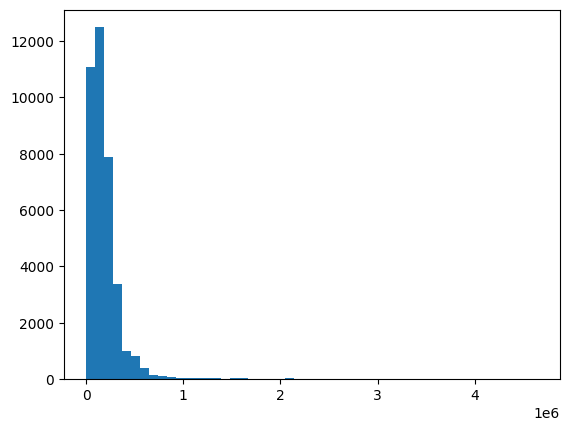

In [13]:
import matplotlib.pyplot as plt
_ = plt.hist(y, bins=50)

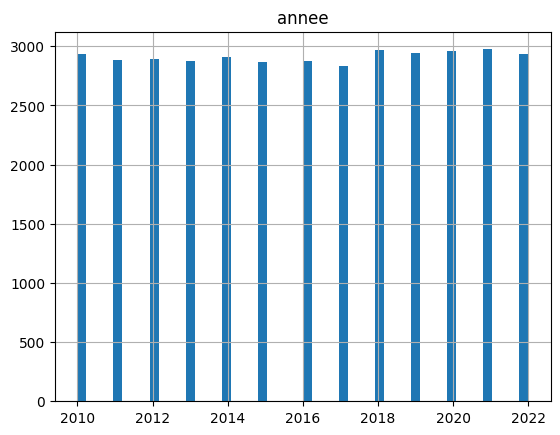

In [14]:
_ = X.hist('annee', bins=50)

In [15]:
X.shape

(37858, 4)

In [16]:
print("moyenne des honoraires : ", y.mean())
print("variance des honoraires :", y.std())

moyenne des honoraires :  193614.17428284642
variance des honoraires : 240161.33319560048


In [17]:
categorical_encoder = OrdinalEncoder()
categorical_cols = ["annee", "profession_sante", "region", "departement"]


In [18]:
preprocessor = make_column_transformer(
    (categorical_encoder, categorical_cols),
    remainder='passthrough',  
)


regressor = RandomForestRegressor(
    n_estimators=10, max_depth=10, max_features=10, n_jobs=4
)

pipeline = make_pipeline(preprocessor, regressor)

pipeline.fit(X, y)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['annee', 'profession_sante',
                                                   'region',
                                                   'departement'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, max_features=10,
                                       n_estimators=10, n_jobs=4))])

In [19]:
X_test, y_test = problem.get_test_data()

y_pred = pipeline.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error
print("RMSE = ", mean_squared_error(y_test, y_pred, squared=False))
print("MAE = ", mean_absolute_error(y_test, y_pred))



RMSE =  111046.15337208255
MAE =  40235.80371996987
